In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import math
from scipy import stats
from bitarray import bitarray
import pickle
import community
from bitarray import bitarray
import scipy
import scipy.fftpack
import sys
import seaborn as sns
from random import gauss
from numpy.random import standard_normal
from scipy.special import erf
from scipy.stats import norm
from scipy.stats import bernoulli
import scipy.fftpack
from IPython import display

sns.set_style('darkgrid')
np.random.seed(0)
#

# Gaussian random field

In [2]:
def fftind(size):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.
        
        Input:
        size (integer): The size of the coordinate array to create
        
        Output:
            k_ind, numpy array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components
    """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = scipy.fftpack.fftshift(k_ind)
    return( k_ind )

In [3]:
def gaussian_random_field(alpha = 3.0, size = 100, flag_normalize = True):
    """ 
    Returns a numpy array of sizexsize discrete Gaussian random field
        
    Input:
    alpha (double, default = 3.0): 
        The power of the power-law momentum distribution
    size (integer, default = 128):
        The size of the square output Gaussian Random Fields
    flag_normalize (boolean, default = True):
        Normalizes the Gaussian Field:
            - to have an average of 0.0
            - to have a standard deviation of 1.0
    Output:
    gfield (numpy array of shape (size, size)):
        The random gaussian random field

    Example:
    import matplotlib
    import matplotlib.pyplot as plt
    example = gaussian_random_field()
    plt.imshow(example)
    """
        
        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0
    
        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))
    
        # To real space
    gfield = np.fft.ifft2(noise * amplitude).real
    
        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield/np.std(gfield)
        
    return gfield

# Some MAB algorithms

In [4]:
def block_ucl(prior_means,prior_variance,variance,n_arms,time_horizon, arms, n, m_bar, random_rewards = True):
    """
    Inputs: 
    prior_means - an array of prior means about the pay-offs of the arms
    prior_variance - prior variance characterising the prior Gaussian distribution, constant for all arms
    variance - variance of Gaussian distributions of each arm, constant for all arms, assumed known before the game begins
    n_arms - number of arms of the MAB
    time_horizon - number of time steps of the game
    arms - set of arms, either input as a probability distribtion (Gaussian) or as an array of pay-offs for each arm
    random_rewards - True if the rewards are drawn i.i.d. from Gaussian distribution at each time step
    
    Output : allocation sequence of arms over the time horizon
    """
    
    
    #### Initialisation
    
    # n[i] denotes the number of pulls of the arm i in t-1 peridos
    # n = np.zeros(n_arms)
    
    # m_bar[i] denotes the mean pay-off as observed in t-1 periods
    # m_bar = np.zeros(n_arms)
    
    # normalise variance
    delta_sq = variance / prior_variance
    
    # K is a tuner variable
    K = math.sqrt(2*math.pi*math.e)
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    # initialise the values of the heuristic function for each arm
    Q = np.zeros(n_arms)
    
    
    #### Iteration
    # at each allocation round pick the arm with maximum upper credible limit
    
    # let l be the smallest index s.t. T<2^l
    l = math.ceil(math.exp(math.log(T)/2))
    
    
    for k in range(1,l+1):
        
        # let bk be the total number of blocks in frame fk:
        bk = math.ceil((2**(k-1))/k)
        
        for r in range(1,bk+1):
            tau = 2**(k-1) + (r-1)*k
            
            for i in range(n_arms):
                # Compute a heuristic value for the current arm
                Q[i] = (delta_sq*prior_means[i]+n[i]*m_bar[i])/(delta_sq+n[i]) + math.sqrt(variance/(delta_sq+n[i]))*norm.ppf(1-1/(K*(tau)))
            
            # select an arm with the maximum value of the heuristic function
            i_hat = np.argmax(Q)
            
            #print (k,tau,2**(k)-tau)
            
            if 2**(k)-tau >= k:
                
                #print ("1")
                
                # select the same arm for the whole duration of the block
                for t in range(tau,tau+k):
                    
                    # terminate the algorithm and return the allocation sequence if the we are past the last time step
                    if t-1>=time_horizon:
                        return alloc_seq
                    
                    #print("if",t-1)
                    
                    if random_rewards == True:
                        # initialise a list of rewards
                        all_rewards = [arms[i].draw() for i in range(n_arms)]
                    else:
                        all_rewards = arms
                    
                    alloc_seq[t-1] = i_hat
                
                    #collect reward
                    rewards[t-1] = all_rewards[i_hat]
                    
                    # update variables
                    m_bar[i_hat] = (n[i_hat]*m_bar[i_hat]+all_rewards[i_hat])/(n[i_hat]+1)
                    n[i_hat] +=1
                    
            else:
                
                #print ("2")
                
                
                for t in range(tau,2**(k)):
                    
                    # terminate the algorithm and return the allocation sequence if the we are past the last time step
                    if t-1>=time_horizon:
                        return alloc_seq
                    
                    #print("else",t-1)
                    
                    if random_rewards == True:
                        # initialise a list of rewards
                        all_rewards = [arms[i].draw() for i in range(n_arms)]
                    else:
                        all_rewards = arms
                    
                    
                    alloc_seq[t-1] = i_hat
                
                    #colect reward
                    rewards[t-1] = all_rewards[i_hat]
                    
                    # update variables
                    m_bar[i_hat] = (n[i_hat]*m_bar[i_hat]+all_rewards[i_hat])/(n[i_hat]+1)
                    n[i_hat] +=1
                    
    return alloc_seq, rewards, n, m_bar

In [5]:
def deterministic_ucl(prior_means,prior_variance,variance,n_arms,time_horizon,arms,  n, m_bar, random_rewards=True):
    """
    Inputs: 
    prior_means - an array of prior means about the pay-offs of the arms
    prior_variance - prior variance characterising the prior Gaussian distribution, constant for all arms
    variance - variance of Gaussian distributions of each arm, constant for all arms, assumed known before the game begins
    n_arms - number of arms of the MAB
    time_horizon - number of time steps of the game
    arms - a list or array of arms together with their reward distribution
    
    Output : allocation sequence of arms over the time horizon
    """
    
    #### Initialisation
    
    # n[i] denotes the number of pulls of the arm i in t-1 peridos
    # n = np.zeros(n_arms)
    
    # m_bar[i] denotes the mean pay-off as observed in t-1 periods
    # m_bar = np.zeros(n_arms)
    
    # normalise variance
    delta_sq = variance / prior_variance
    
    # K is a tuner variable
    K = math.sqrt(2*math.pi*math.e)
    
    # rewards array
    rewards = np.zeros(time_horizon)
    
    # allocation sequence (output)
    alloc_seq = np.zeros(time_horizon)
    
    # initialise the values of the heuristic function for each arm
    Q = np.zeros(n_arms)
    
    #### Iteration
    # at each time pick the arm with maximum upper credible limit (UCL)
    for t in range(time_horizon):
        
        if random_rewards==True:
            # initialise a list of rewards
            all_rewards = [arms[i].draw() for i in range(n_arms)]
        else:
            all_rewards = arms
        
        for i in range(n_arms):
            # Compute a heuristic value for the current arm
            Q[i] = (delta_sq*prior_means[i]+n[i]*m_bar[i])/(delta_sq+n[i]) + (math.sqrt(variance/(delta_sq+n[i])))*norm.ppf(1-1/(K*(t+1)))
        
        #print("Q:",Q)
        #print('argmaxQ:',np.argmax(Q),'maxQ:',np.max(Q))
        
        # select an arm with the highest heuristic function value
        selected_arm = np.argmax(Q)
        alloc_seq[t] = selected_arm
        
        
        # collect reward m_real
        rewards[t] = all_rewards[selected_arm]
        
        #print ('all rewards:', all_rewards)
        
        # update variables
        m_bar[selected_arm] = (n[selected_arm]*m_bar[selected_arm] + all_rewards[selected_arm]) / (n[selected_arm] + 1)
        n[selected_arm] += 1
        
        #print ('m_bar:',m_bar)
        #print ('n:',n)
    
    return alloc_seq, rewards, n, m_bar

In [6]:
def find_min_diff(arr, n): 
    """
    Returns minimum difference between any pair of elements in an array
    
    arr - numpy array
    n - number of elements in the array used in the process
    """
    
    # Sort array in non-decreasing order 
    arr = sorted(arr) 
  
    # Initialize difference as infinite 
    diff = 10**20
  
    # Find the min diff by comparing adjacent 
    # pairs in sorted array 
    for i in range(n-1): 
        if abs(arr[i+1] - arr[i]) < diff: 
            diff = abs(arr[i+1] - arr[i]) 
  
    # Return min diff 
    return diff

In [7]:
def field_to_arms(rand_field):
    """
    transforms an nxn grid generated as a random field to set of n^2 arms
    
    rand_field - Gaussian random field
    """
    return rand_field.ravel()

In [8]:
def arms_to_field(arms,n):
    """
    Transforms an allocation sequence to sequence of 2D coordinates in the same structure as the field
    
    arms - an allocation sequence
    """
    return arms%n,arms//n 

# Social interactions

In [9]:
#### This should be useful when we add network dynamics


class Graph(nx.MultiDiGraph):
    """Soe useful methods for multi directed graph"""
    pos=None
    _label=None
    
    def __str__(self):
        if self._label:
            return self._label
        return nx.MultiDiGraph.__repr__(self)
    
    def levels_layout(self,ranks=None,xpos=None):
        pos={}
        refpos=nx.spring_layout(self)
        if not isinstance(xpos,dict):
            xpos={i:j for i,j in zip(self.nodes(),xpos ) }
        maxx,maxy=np.max(refpos.values(),axis=0)
        for i,d in self.nodes(data=True):
            if not xpos is None and i in xpos:
                x=xpos[i]
            else:
                x= np.random.random()*maxx
            if ranks is None:
                y=d['height']*maxy
            else:
                y=ranks[i]
            pos[i]=x,y
        self.pos=pos

    def plot(self,newfig=True,hold=False,labels=None,edge_labels=None,nscale=1,minsize=0.001,**kwargs):
        '''Use matplotlib to plot the network'''
        
        if self.pos is None:
            pos=self.pos=nx.spring_layout(self)
        else:
            pos=self.pos
        if newfig:
            plt.figure()
        node_size=np.ones(len(self.node) ) *kwargs.get('node_size',1)
        node_size[node_size<minsize]=0
        node_size/=np.max(node_size)/2.
        node_size[node_size>0]=np.clip(node_size[node_size>0],0.1,None)*nscale


        node_size[np.random.random(node_size.shape )<kwargs.get('subsample',0)  ]=0
        nodidx={n:i for i,n in enumerate(self.nodes()) }

        edge_width=kwargs.get('edge_width',1)
        if edge_width:
            sign=kwargs.get('sign',0)
            if not sign or sign<0:
                nx.draw_networkx_edges(self,pos=pos,edgelist=[(i,j) for i,j,d in
                    self.edges(data=True) if d.get('weight',0)<0 and node_size[nodidx[i]]*node_size[nodidx[j]]>0],
                    edge_color='r',width=edge_width )
            if not sign or sign>0:
                nx.draw_networkx_edges(self,pos=pos,edgelist=[(i,j) for i,j,d in
                    self.edges(data=True) if d.get('weight',0)>=0 and node_size[nodidx[i]]*node_size[nodidx[j]]>0.],
                    edge_color='b',width=edge_width )
        nx.draw_networkx_nodes(self,pos=pos ,node_size=node_size*200.,linewidths=0,
                node_color= ifelse('node_color' in kwargs, np.array(kwargs.get('node_color',[])),'blue') )
        if labels is None:
            labels={n:str(n) for n in self.nodes() }
        elif not isinstance(labels,dict):
            labels={n:labels[i] for i,n in enumerate(self.nodes()) }
        nx.draw_networkx_labels(self,pos=pos,labels={n:l for n,l in labels.items() if node_size[nodidx[n]]>0} )
        if not edge_labels is None:
            if edge_labels=='weights':
                #print [self.edge[j][i][0] for i,j,d in
                    #self.edges(data=True)]
                edge_labels={(i,j):'{:.2f},{:.2f}'.format(self.edge[i][j][0]['weight'],self.edge[j][i][0]['weight']) for i,j,d in
                    self.edges(data=True) if # self.edge[i][j][0]['weight']>-self.edge[j][i][0]['weight'] and
                      node_size[nodidx[i]]*node_size[nodidx[j]]>0}
            nx.draw_networkx_edge_labels(self,pos=pos,edge_labels= edge_labels )
        if 'title' in kwargs:
            plt.title(kwargs['title'])
        if 'xlabel' in kwargs:
            plt.xlabel(kwargs['xlabel'])
        if 'ylabel' in kwargs:
            plt.ylabel(kwargs['ylabel'])
        if not hold:
            plt.show()

In [10]:
G = nx.Graph()

G.add_nodes_from(range(5))

A = nx.complete_graph(5)

A.nodes()
A.edges()

A.add_weighted_edges_from((u,v,random.random()) for u,v in A.edges())
A.edges()


[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [11]:
def add_weights_complete_graph(graph, const = True, comm_prop = 0.5):
    """
    Add weights to a graph.
    
    Inputs:
    graph - networkx type graph
    const - True if the weights are constant
    comm_prop - communication propensity in the network
    
    Output:
    weighted graph
    """
    
    return graph.add_weighted_edges_from((u,v,comm_prop) for u,v in graph.edges())

In [12]:
def comm_graph_heavyside(n,a):
    """
    Produces a complete graph with weights according to a smooth approximation to a heavy-side step function
    
    Inputs:
    n - number of nodes
    a - parameter input to the heavy-side step function
    
    Output:
    complete weighted graph
    """
    
    # intialise the graph
    G=nx.complete_graph(n)
    
    # add edges with weights
    G.add_weighted_edges_from((u,v,heavy_side_step(u,v,a)) for u,v in G.edges())
    
    return G

In [13]:
def heavy_side_step(x,y,a):
    """
    Compute a smooth approximation to a heavy-side step function of distance between x,y using the usual Euclidean metric
    """
    return 1/(1+math.exp(a*abs(x-y)))

In [14]:
A = comm_graph_heavyside(10,0.1)

A.edges(data=True)


[(0, 1, {'weight': 0.47502081252106}),
 (0, 2, {'weight': 0.45016600268752216}),
 (0, 3, {'weight': 0.425557483188341}),
 (0, 4, {'weight': 0.401312339887548}),
 (0, 5, {'weight': 0.3775406687981454}),
 (0, 6, {'weight': 0.35434369377420455}),
 (0, 7, {'weight': 0.3318122278318339}),
 (0, 8, {'weight': 0.31002551887238755}),
 (0, 9, {'weight': 0.289050497374996}),
 (1, 2, {'weight': 0.47502081252106}),
 (1, 3, {'weight': 0.45016600268752216}),
 (1, 4, {'weight': 0.425557483188341}),
 (1, 5, {'weight': 0.401312339887548}),
 (1, 6, {'weight': 0.3775406687981454}),
 (1, 7, {'weight': 0.35434369377420455}),
 (1, 8, {'weight': 0.3318122278318339}),
 (1, 9, {'weight': 0.31002551887238755}),
 (2, 3, {'weight': 0.47502081252106}),
 (2, 4, {'weight': 0.45016600268752216}),
 (2, 5, {'weight': 0.425557483188341}),
 (2, 6, {'weight': 0.401312339887548}),
 (2, 7, {'weight': 0.3775406687981454}),
 (2, 8, {'weight': 0.35434369377420455}),
 (2, 9, {'weight': 0.3318122278318339}),
 (3, 4, {'weight': 0.

# Simulations

In [15]:
global b, N, payoff, K

# K is number of arms of the multi-armed bandit
K = 400

In [16]:
# initialise network of agents
G = comm_graph_heavyside(10,0.1)

In [17]:
# initialise payoff and strategy fields
def init(network) :
    """adds payoff and strategy fields to each node
    """
    
    global N
    global K
    n = N = len(network)
    cnt = 0
    network.graph['degrees'] = [network.degree(node) for node in network.nodes()] #just to check for now, as we know the graph is complete
    for i in range(n) :
        network.node[i]['payoff'] = 0 #average pay-off from all observed rewards
        network.node[i]['alloc_seq'] = np.empty(0) #this will be the array of payoff from the multi-armed bandit
        network.node[i]['rewards'] = np.empty(0)
        network.node[i]['strategy'] = None #UPDATE
        network.node[i]['next strategy'] = None
        network.node[i]['neighbors'] = network.neighbors(i) #all other nodes for now
        network.node[i]['fitness'] = 0
        network.node[i]['arm'] = 0 #current location of the agent
        network.node[i]['prior means'] = np.zeros(K)
        network.node[i]['m_bar'] = np.zeros(K)
        network.node[i]['n'] = np.zeros(K)
        network.node[i]['prior variance'] = 1
        network.node[i]['variance'] = 1
        network.node[i]['game played with'] = np.empty(0) #with whom was the game already played? i.e. with whome has this individual tried
                                                        # to share information?
        network.node[i]['information shared with'] = np.empty(0) # with whom of the neighbors was a subset of the information set during
                                                            # the particular iteration?
        
    
    # TO-DO fix later with evolutionary strategies - distribute evenly and randomly among players
    """while cnt < n/2 :
        s = mt.floor(rd.random()*n)
        if not network.node[s]['strategy'] :
            network.node[s]['strategy'] = True
            cnt = cnt + 1"""

In [18]:
def initialise_pos(network,field):
    """
    Initialise the position of the agents in the field
    """
    for i in range(len(network)):
        if np.all(network.node[i]['prior means']==network.node[i]['prior means'][0]):
            arm = random.randint(0,K-1)
            network.node[i]['arm'] = arm
            network.node[i]['n'][arm] += 1
            network.node[i]['m_bar'][arm] = field_to_arms(field)[arm]
            network.node[i]['alloc_seq'] = np.append(network.node[i]['alloc_seq'],arm)
            network.node[i]['rewards'] = np.append(network.node[i]['rewards'],field_to_arms(field)[arm])

In [19]:
init(G)

# print (G.nodes(data=True))
# print (G.edges(data=True))

G.edge[1][8]['weight']

0.3318122278318339

In [20]:
def arm_selection(network,field,alg=deterministic_ucl):
    """
    Performs one round when the agents select an arm based on a specified algorithm and assign the allocation
    sequence and array of rewards to the corresponding agent.
    
    Inputs:
    network - network of social interactions
    field - Gaussian random field
    alg - which allocation algorithm will be used (default: deterministic)
    """
    
    arms = field_to_arms(field)
    
    
    if alg == deterministic_ucl:
        for i in range(len(network)):
            priors = network.node[i]['prior means']
            prior_var = network.node[i]['prior variance']
            variance = network.node[i]['variance']
            n_arms = arms.size
            n_visits = network.node[i]['n']
            avg_arms = network.node[i]['m_bar']
            time_horizon = 1
            a,b,n,m_bar = deterministic_ucl(priors,prior_var,variance,n_arms,time_horizon,arms,n_visits, avg_arms,random_rewards=False)
            network.node[i]['alloc_seq'] = np.append(network.node[i]['alloc_seq'],a)
            network.node[i]['rewards'] = np.append(network.node[i]['rewards'],b)
            network.node[i]['prior mean'] = np.mean(network.node[i]['rewards']) #update priors to have them ready for next iteration 
            network.node[i]['n'] = network.node[i]['n'] + n
            network.node[i]['m_bar'] = network.node[i]['m_bar'] + m_bar
    
    elif alg == block_ucl:
        for i in range(len(network)):
            priors = network.node[i]['prior means']
            prior_var = network.node[i]['prior variance']
            variance = network.node[i]['variance']
            n_arms = arms.size
            time_horizon = 1
            a,b,n, m_bar = block_ucl(priors,prior_var,variance,n_arms,time_horizon,arms,n_visits, avg_arms, random_rewards=False)
            network.node[i]['alloc_seq'] = np.append(network.node[i]['alloc_seq'],arms_to_field(a,math.sqrt(n_arms)))
            network.node[i]['rewards'] = np.append(network.node[i]['rewards'],b)
            network.node[i]['prior mean'] = np.mean(network.node[i]['rewards']) #update priors to have them ready for next iteration
            network.node[i]['n'] = network.node[i]['n'] + n
            network.node[i]['m_bar'] = network.node[i]['m_bar'] + m_bar

In [21]:
def information_sharing(network):
    """
    Performs one step of information sharing
    """
    
    # initialise the fields
    for i in range(len(network)):
        network.node[i]['game played with'] = np.empty(0) #with whom was the game already played? i.e. with whome has this individual tried
                                                            # to share information?
        network.node[i]['information shared with'] = np.empty(0) # with whom of the neighbors was a subset of the information set during
                                                                # the particular iteration?

    for i in range(len(network)):
        if np.all(network.node[i]['neighbors'] == network.node[i]['game played with']):
            pass
        
        to_iterate_over = np.setdiff1d(network.node[i]['neighbors'],network.node[i]['game played with'])
        
        #print(i,to_iterate_over)
        
        for j in to_iterate_over:
            
            network.node[i]['game played with'] = np.append(network.node[i]['game played with'],j)
            network.node[j]['game played with'] = np.append(network.node[j]['game played with'],i)
            
            if network.edge[i][j]['weight']*network.node[i]['alloc_seq'].size < 1:
                if network.edge[i][j]['weight'] > random.random():
                    n_to_share = min(network.node[i]['alloc_seq'].size,network.node[j]['alloc_seq'].size)
                    network.node[j]['information shared with'] = np.append(network.node[j]['information shared with'],i)
                    network.node[i]['information shared with'] = np.append(network.node[i]['information shared with'],j)
                else:
                    n_to_share = 0
            else:
                n_to_share = math.floor(network.edge[i][j]['weight']*network.node[i]['alloc_seq'].size)
                network.node[j]['information shared with'] = np.append(network.node[j]['information shared with'],i)
                network.node[i]['information shared with'] = np.append(network.node[i]['information shared with'],j)
                
            if n_to_share != 0:
                #i shares with j:
                for arm, reward in zip(network.node[i]['alloc_seq'][-n_to_share:],network.node[i]['rewards'][-n_to_share:]):
                    network.node[j]['m_bar'][arm] = (network.node[j]['m_bar'][arm]*network.node[j]['n'][arm] + reward)/(network.node[j]['n'][arm]+1)
                    network.node[j]['n'][arm] += 1

                #j shares with i:
                for arm, reward in zip(network.node[j]['alloc_seq'][-n_to_share:],network.node[j]['rewards'][-n_to_share:]):
                    network.node[i]['m_bar'][arm] = (network.node[i]['m_bar'][arm]*network.node[i]['n'][arm] + reward)/(network.node[i]['n'][arm]+1)
                    network.node[i]['n'][arm] += 1

In [22]:
a = np.array([1,2,3])
b = np.array([5,6,7])

for u,v in zip(a,b):
    print (u,v)
    
print (a[-3:])



1 5
2 6
3 7
[1 2 3]


One option is to have communities

In [23]:
def community_init(network) :
    """Initialise pay-offs based on community membership"""
    n = len(network)
    partition = community.best_partition(network)
    community_index = sorted(set(partition.values()))
    num_communities = max(community_index)+1
    comm_strat = [True if k < num_communities/2 else False for k in community_index]
    rd.shuffle(comm_strat)
    network.graph['degrees'] =  [network.degree(node) 
                                for node in network.nodes()]
    for i in range(n) :
        network.node[i]['strategy'] = comm_strat[partition[i]]
        network.node[i]['next strategy'] = None
        network.node[i]['neighbors'] = network.neighbors(i)
        network.node[i]['payoff'] = 0 #average pay-off from all observed rewards
        network.node[i]['alloc_seq'] = [] #this will be the array of payoff from the multi-armed bandit
        network.node[i]['rewards'] = []
        network.node[i]['fitness'] = 0
        network.node[i]['arm'] = 0 #current location of the agent

In [24]:
def record_data(network, data_array):
    """take single iteration snapshot of node strategies"""
    for n in network.nodes() :
        data_array[n] = network.node[n]['strategy']

In [25]:
def new_strategy(network, node):
    """return new strategy for a single node"""
    global b
    if not network.node[node]['neighbors'] : #in the case of an isolated vertex
        return network.node[node]['strategy']
    v = rd.choice(network.node[node]['neighbors'])
    if network.node[node]['payoff'] < network.node[v]['payoff'] :
        p = (network.node[v]['payoff'] - network.node[node]['payoff'])/(max(network.graph['degrees'][node], network.graph['degrees'][v])*b*100.0)
        s = rd.random()
        if (s < p) :
            return network.node[v]['strategy']
    return network.node[node]['strategy']

In [26]:
def strategy_update(network):
    """update strategy of each node"""
    new_strategies = [new_strategy(network, u) for u in network.nodes()]
    for q in network.nodes() :
        network.node[q]['strategy'] = new_strategies[q]

In [27]:
def run_network_game(network):
    """update node payoffs"""
    for u in network.nodes() :
        network.node[u]['payoff'] = np.mean(network.node[u]['rewards'])

In [28]:
def accum_payoff(network, u):
    """return the acumulated payoff of node u"""
    global payoff
    p = 0
    s_u = network.node[u]['strategy']
    for v in network.node[u]['neighbors'] :
        s_v = network.node[v]['strategy']
        p += payoff[s_u][s_v]
    return p

In [29]:
def sim(network,field,n_mix=10000,n_data=1000):
    """run the simulation for n_mix+n_data times and return data for last n_data iterations,
    collect data on """
    global K
    data = [[0 for x in network.nodes()] for y in range(int(n_data))]
    """for i in range(n_mix):
        information_sharing(network)
        arm_selection(network,field)"""
    for j in range(n_data):
        information_sharing(network)
        arm_selection(network,field)
        record_data_sharing(network,data[j])
    return data

In [30]:
def record_data_sharing(network, data_array) :
    """take single iteration snapshot of the rate of communication"""
    for n in network.nodes() :
        data_array[n] = np.mean(network.node[n]['rewards'])

In [31]:
def full_sim(network, B, n_mix=int(1e4), n_data = int(1e3), comm_init=False):
    """Full simulation - NOTE: ADD VARIOUS VALUES OF THE PROPENSITY TO SHARE INFORMATION"""
    global K
    initialise = init if comm_init is False else community_init
    add_weights_complete_graph(network, const = True, comm_prop = B)
    initialise(network)
    field = gaussian_random_field(size = math.sqrt(K), flag_normalize = True)
    initialise_pos(network,field)
    data = sim(network, field, n_mix, n_data)
    return data

In [32]:
# get data for specified network over full range of b values
def get_simulation_data(network, n_mix = 10000, n_data = 1000, n_steps = 20, comm_init=False) :
    data = [None for x in range(n_steps)]
    for i in range(n_steps) :
        print(str(i/float(n_steps)*100)+'%')
        data[i] = full_sim(network, i/float(n_steps), n_mix, n_data, comm_init)
    return data

In [38]:
network = nx.complete_graph(10)

results = get_simulation_data(network, n_mix = 10, n_data = 10, n_steps = 5, comm_init=False)

0.0%


C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


20.0%


C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


40.0%
60.0%
80.0%


In [34]:
network = nx.complete_graph(5)
add_weights_complete_graph(network, const = True, comm_prop = 0.5)
init(network)
field = gaussian_random_field(size = math.sqrt(K), flag_normalize = True)
initialise_pos(network,field)


C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [35]:
information_sharing(network)
network.nodes(data=True)

C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[(0,
  {'alloc_seq': array([ 330.]),
   'arm': 330,
   'fitness': 0,
   'game played with': array([ 1.,  2.,  3.,  4.]),
   'information shared with': array([ 1.,  2.,  3.]),
   'm_bar': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0. 

In [36]:
arm_selection(network,field)
network.nodes(data=True)

[(0,
  {'alloc_seq': array([ 330.,  178.]),
   'arm': 330,
   'fitness': 0,
   'game played with': array([ 1.,  2.,  3.,  4.]),
   'information shared with': array([ 1.,  2.,  3.]),
   'm_bar': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.       

0.0%


C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


20.0%


C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


40.0%
60.0%
80.0%


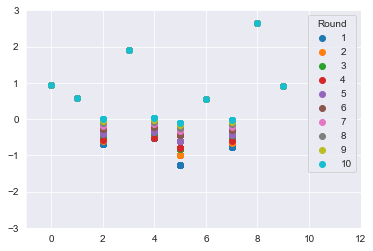

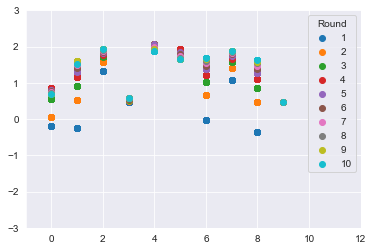

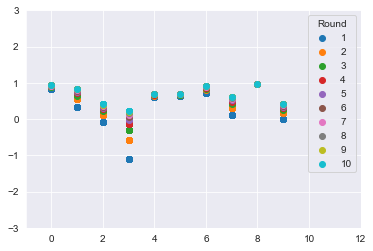

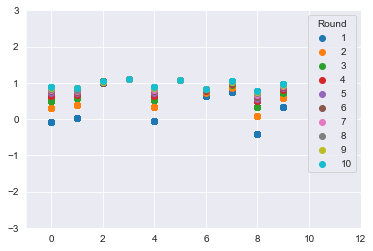

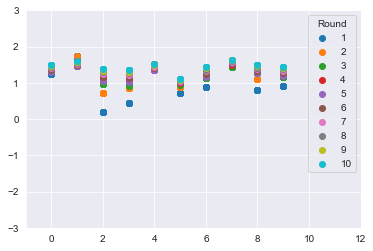

In [80]:
G = nx.complete_graph(10)

res = get_simulation_data(G, n_mix = 0, n_data = 10, n_steps = 5, comm_init=False)


for results in res:
    i =0
    for line in results:
        r = 1
        x_s = range(10)
        for it in results:
            if i==0:
                plt.scatter(x_s,it,label=r)
            else:
                plt.scatter(x_s,it)
            r+=1
        i=i+1

    plt.legend(loc="upper right", title="Round")
    plt.ylim(-3, 3)
    plt.xlim(-1,12)
    plt.show()